In [2]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

According to Kohonen, we can do about 50 datapoints per node. For 3.5k that means maybe 60-80 nodes.
I want a 5x4 resolution for display reasons, so maybe 10x8 nodes?

In [3]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:03<00:00, 6122.41it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [4]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [5]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'pineapple', 'sweet', 'banana', 'tropical', 'cherry', 'fruity'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [252]:
class SOM(object):
    def __init__(self,width,height,lr=1e-1,gauss=10,decay=.99,use_onehot=True):
        self.use_onehot = use_onehot
        
        if use_onehot:
            # Select a random index to use as the hot element.
            idxs = torch.randint(low=0,high=len(all_notes),size=(width,height))
            # Convert to one hot of shape.
            self.vectors = torch.nn.functional.one_hot(idxs,num_classes=len(all_notes)).float()
        else:
            self.vectors = torch.rand(size=(width,height,len(all_notes))).float()
        
        map_x_idx, map_y_idx = torch.meshgrid(torch.arange(start=0,end=width), torch.arange(start=0,end=height), indexing='ij')
        self.map_idx = torch.stack([map_x_idx,map_y_idx],dim=-1)

        self.lr = lr
        self.gauss = gauss
        self.decay = decay

    def get_lr(self):
        return self.lr

    def do_decay(self):
        self.lr *= self.decay
        self.gauss *= self.decay

    def get_activations(self,encoding):
        if self.use_onehot:
            return torch.nn.functional.cosine_similarity(self.vectors, encoding, dim=-1)
        else:
            # Activation is 1 / Euclidian(vectors, encoding).
            # The closer a vector is to the encoding, the higher the activation.
            return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        # Especially at the beginning of training, there may be a larger amount
        # of vectors that are equidistant to the encoding. 
        bmu_idxs = (actvtn==torch.max(actvtn)).nonzero()
        # In order to prevent embedding collapse, we select one randomly as the bmu.
        selected = np.random.randint(low=0,high=len(bmu_idxs))
        return bmu_idxs[selected]

    def get_loss(self,encoding):
        actvtn = self.get_activations(encoding)
        if self.use_onehot:
            # max cosine similarity is 1, so best loss is 1 - 1 = 0
            return 1-torch.max(actvtn)
        else:
            # Convert back to distances to calculate loss
            # The loss is the lowest distance, so minimizing loss
            # means a better match.
            return torch.min(1/actvtn)

    def get_distances(self,bmu):
        xy_dist = self.map_idx - bmu
        return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

    def update_factor(self,bmu):
        dists = self.get_distances(bmu)
        # Gaussian distribution centered on BMU of width 2^gauss.
        return torch.exp(torch.neg(torch.div(dists.square(), self.gauss**2)))

    def get_deltas(self,encoding):
        return encoding-self.vectors

    def update_step(self,encoding):
        bmu = self.get_bmu(encoding)
        uf = self.update_factor(bmu)
        deltas = self.get_deltas(encoding)
        self.vectors += self.lr*uf.unsqueeze(-1)*deltas
        if self.use_onehot:
            # Vectors are normalized to a fixed length as recommended by Kohnonen.
            self.vectors = torch.nn.functional.normalize(self.vectors,dim=-1)

In [246]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)

def do_train(config,verbose=False):
    total_steps = config["bsz"]*config["batches"]
    

    som = SOM(width=config["width"],
              height=config["height"],
              lr=config["lr"],
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"])
    
    def do_train_step(s):
        slr = config["lr"]*(1 - (s/total_steps))
        mol = random.choice(train_mols)
        return som.update_step(mol["encoding"])
    
    def get_test_loss():
        es = []
        for mol in test_mols:
            es.append(som.get_loss(mol["encoding"]))
        return np.mean(es)

    lrs = []
    losses = []
    for s in tqdm.tqdm(range(total_steps),smoothing=0, disable=not verbose):
        do_train_step(s)
        if s % config["bsz"] == 0:
            losses.append(get_test_loss())
            som.do_decay()
            lrs.append(som.get_lr())

    return som, losses, lrs

100%|███████████████████████████████████| 12800/12800 [00:12<00:00, 1033.17it/s]

fruity tensor([0, 7])
green tensor([7, 7])
sweet tensor([4, 3])
floral tensor([6, 0])
woody tensor([0, 1])
herbal tensor([9, 6])
fresh tensor([7, 4])
fatty tensor([9, 2])
waxy tensor([7, 2])
spicy tensor([3, 2])


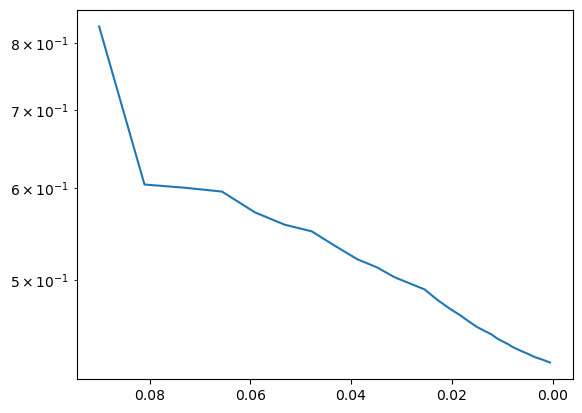

0.4244885


In [257]:
som, loss, lrs = do_train({'width': 5*2, 'height': 4*2, 'bsz': 2**8, 'batches': 50, 'lr': 1e-1, "gauss":5, "decay": .9, "onehot": True},verbose=True)
plt.plot(lrs,loss)
plt.yscale('log')
# loss decreases over time, so plot by decreasing lr.
plt.gca().invert_xaxis()
for n, f in all_notes.most_common(10):
    print(n,som.get_bmu(multi_hot([n])))
plt.show()
print(loss[-1])
    

In [255]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

def plot(title,encoding,as_size,factor=1,thresh=1e-5,activations=None):
    bmu = som.get_bmu(encoding)
    if not torch.is_tensor(activations):
        activations = som.get_activations(encoding)
    
    act = flatten(activations)
    minv, maxv = act.min().numpy(), act.max().numpy()
    
    pos = flatten(som.map_idx).numpy()
    
    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw tiny circles.
        act = torch.nn.functional.threshold(act,thresh,0)
        plt.scatter(pos[:,0],pos[:,1],s=factor*act.numpy())
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*act.numpy())
        plt.set_cmap('PiYG_r')
        plt.colorbar()
        # cbar.lim(minv,maxv)

    plt.title(f"{title}\nBMU of {bmu.numpy()} w/ value = {activations[bmu[0],bmu[1]]}. Range = ({minv:.2f}, {maxv:.2f})")


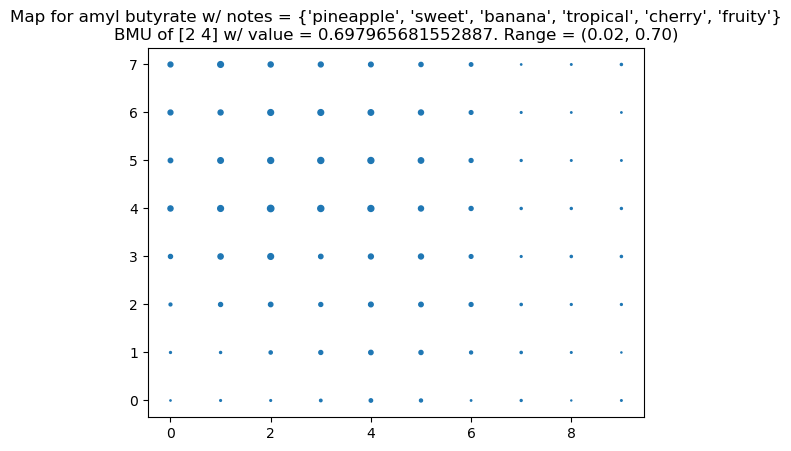

In [258]:
plot(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     factor=30)

plt.show()

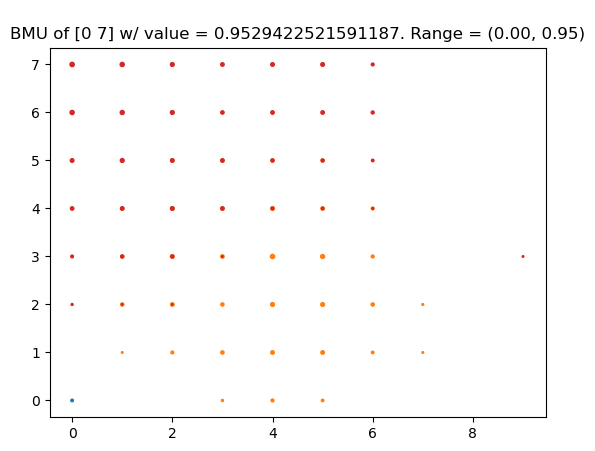

In [268]:
plot("",multi_hot(["musk"]),as_size=True,thresh=1e-1,factor=10)
plot("",multi_hot(["sweet"]),as_size=True,thresh=1e-1,factor=10)
plot("",multi_hot(["sour"]),as_size=True,thresh=1e-1,factor=10)
plot("",multi_hot(["fruity"]),as_size=True,thresh=1e-1,factor=10)
plt.show()


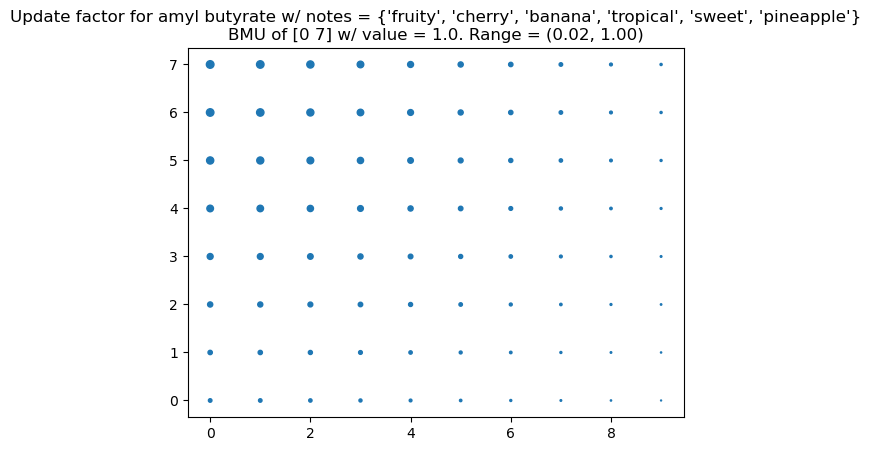

In [402]:
plot(f"Update factor for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     factor=30,
     activations= som.update_factor(som.get_bmu(molecules[0]["encoding"])))

plt.show()

In [259]:
for n, f in all_notes.most_common(50):
    # plot(n,multi_hot([n]),as_size=True,thresh=1e-1)
    # plt.show()
    print(n,som.get_bmu(multi_hot([n])))

fruity tensor([0, 7])
green tensor([7, 7])
sweet tensor([4, 3])
floral tensor([6, 0])
woody tensor([0, 1])
herbal tensor([9, 6])
fresh tensor([7, 4])
fatty tensor([9, 2])
waxy tensor([7, 2])
spicy tensor([3, 2])
rose tensor([6, 0])
citrus tensor([7, 3])
earthy tensor([9, 7])
tropical tensor([4, 5])
oily tensor([9, 2])
nutty tensor([8, 0])
balsamic tensor([4, 0])
sulfurous tensor([9, 0])
vegetable tensor([9, 0])
powdery tensor([4, 2])
creamy tensor([8, 2])
musty tensor([8, 1])
apple tensor([2, 7])
minty tensor([3, 0])
pineapple tensor([2, 6])
meaty tensor([9, 1])
aldehydic tensor([7, 3])
phenolic tensor([3, 0])
dry tensor([0, 0])
caramellic tensor([3, 3])
roasted tensor([8, 0])
berry tensor([0, 3])
ethereal tensor([1, 7])
honey tensor([4, 0])
metallic tensor([8, 6])
camphoreous tensor([2, 0])
leafy tensor([7, 5])
pungent tensor([9, 1])
clean tensor([7, 2])
winey tensor([1, 6])
pear tensor([3, 6])
coconut tensor([2, 5])
jasmin tensor([6, 0])
animal tensor([4, 0])
melon tensor([9, 3])
che